In [1]:
import pandas as pd
import pandas_datareader.data as web
import pandas_datareader.famafrench as ff
import datetime
import matplotlib.pyplot as plt
from keras import Sequential
from keras.layers import LSTM, Dense, Reshape
import numpy as np
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


In [2]:
np.set_printoptions(linewidth=160)
pd.set_option('display.max_columns', None)

In [3]:
start = datetime.datetime(1998, 1, 1)
end = datetime.datetime(2021, 1, 1)

tickers = pd.read_csv("DJIA.csv", header=None) # components as of 2021-03-09
tickers = list(tickers[0])
for ticker in tickers:
    print(ticker)

MMM
AXP
AMGN
AAPL
BA
CAT
CVX
CSCO
KO
DOW
GS
HD
HON
IBM
INTC
JNJ
JPM
MCD
MRK
MSFT
NKE
PG
CRM
TRV
UNH
VZ
V
WBA
WMT
DIS


In [4]:
ff.get_available_datasets()

['F-F_Research_Data_Factors',
 'F-F_Research_Data_Factors_weekly',
 'F-F_Research_Data_Factors_daily',
 'F-F_Research_Data_5_Factors_2x3',
 'F-F_Research_Data_5_Factors_2x3_daily',
 'Portfolios_Formed_on_ME',
 'Portfolios_Formed_on_ME_Wout_Div',
 'Portfolios_Formed_on_ME_Daily',
 'Portfolios_Formed_on_BE-ME',
 'Portfolios_Formed_on_BE-ME_Wout_Div',
 'Portfolios_Formed_on_BE-ME_Daily',
 'Portfolios_Formed_on_OP',
 'Portfolios_Formed_on_OP_Wout_Div',
 'Portfolios_Formed_on_OP_Daily',
 'Portfolios_Formed_on_INV',
 'Portfolios_Formed_on_INV_Wout_Div',
 'Portfolios_Formed_on_INV_Daily',
 '6_Portfolios_2x3',
 '6_Portfolios_2x3_Wout_Div',
 '6_Portfolios_2x3_weekly',
 '6_Portfolios_2x3_daily',
 '25_Portfolios_5x5',
 '25_Portfolios_5x5_Wout_Div',
 '25_Portfolios_5x5_Daily',
 '100_Portfolios_10x10',
 '100_Portfolios_10x10_Wout_Div',
 '100_Portfolios_10x10_Daily',
 '6_Portfolios_ME_OP_2x3',
 '6_Portfolios_ME_OP_2x3_Wout_Div',
 '6_Portfolios_ME_OP_2x3_daily',
 '25_Portfolios_ME_OP_5x5',
 '25_Portf

In [5]:
ff_dict = web.DataReader('North_America_5_Factors_Daily', "famafrench", start, end)
print(ff_dict.pop("DESCR"))
ff_dict = ff_dict[0]

North America 5 Factors Daily
-----------------------------

This file was created using the 202101 Bloomberg database. Missing data are indicated by -99.99. 

  0 : (6002 rows x 6 cols)


In [6]:
factors = pd.DataFrame(ff_dict)
factors.index = pd.to_datetime(factors.index.to_timestamp())
factors

,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,
1998-01-01,-0.02,0.00,0.00,0.00,0.00,0.02
1998-01-02,0.23,-0.08,-0.54,0.15,-0.19,0.02
1998-01-05,0.24,-0.03,-0.39,0.11,0.01,0.02
1998-01-06,-1.09,0.25,0.01,-0.21,0.09,0.02
1998-01-07,-0.37,-0.27,-0.19,0.22,0.35,0.02
...,...,...,...,...,...,...
2020-12-28,0.50,-0.86,0.34,1.05,0.39,0.00
2020-12-29,-0.36,-1.17,0.29,0.54,0.12,0.00
2020-12-30,0.30,1.00,0.37,-0.49,0.22,0.00


In [7]:
mom_dict = web.DataReader('North_America_MOM_Factor_Daily', "famafrench", start, end)
print(mom_dict.pop("DESCR"))
mom_dict = mom_dict[0]
mom_factors = pd.DataFrame(mom_dict)
mom_factors.index = pd.to_datetime(mom_factors.index.to_timestamp())
mom_factors

North America MOM Factor Daily
------------------------------

This file was created using the 202101 Bloomberg database. Missing data are indicated by -99.99. 

  0 : (6002 rows x 1 cols)


,WML
Date,
1998-01-01,0.00
1998-01-02,-1.16
1998-01-05,0.14
1998-01-06,0.07
1998-01-07,-0.45
...,...
2020-12-28,-0.76
2020-12-29,-0.41
2020-12-30,-0.01


In [8]:
COMPUSTAT = pd.read_csv("p9o3mgqulrwmikax.csv")
COMPUSTAT.dropna(thresh=COMPUSTAT.shape[0]*0.99,how='all',axis=1, inplace=True) # REMOVE FEATURE IF NaN > 10%
COMPUSTAT=COMPUSTAT[COMPUSTAT.isna().sum().sort_values().keys()]
COMPUSTAT.set_index(pd.to_datetime(COMPUSTAT["public_date"], format="%Y%m%d"), inplace=True) # TODO IS THIS CORRECT?
COMPUSTAT = COMPUSTAT.drop(columns = ["gvkey", "permno", "qdate", "adate", "public_date", "cusip"])
COMPUSTAT[COMPUSTAT["TICKER"]=="MMM"]

,rd_sale,sale_invcap,GProf,ptpm,gpm,opmad,equity_invcap,npm,ps,opmbd,staff_sale,adv_sale,TICKER,de_ratio,debt_assets,cash_lt,aftret_eq,aftret_equity,at_turn,roa,pcf,accrual,debt_capital,bm,ptb,sale_equity,debt_at,totdebt_invcap,debt_invcap,capital_ratio,lt_debt,pe_inc,cash_debt,roe
public_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1970-01-31,0.000,1.592,0.604,0.231,0.500,0.230,0.977,0.112,3.398,0.269,0.279,0.000,MMM,0.338,0.251,0.364,0.197,0.197,1.279,0.344,31.044,0.014,NaN,0.152,6.346,1.629,0.030,0.040,0.013,0.013,0.040,31.564,0.604,0.197
1970-02-28,0.048,1.594,0.601,0.227,0.501,0.220,0.972,0.111,3.686,0.260,0.281,0.000,MMM,0.360,0.263,0.292,0.194,0.194,1.287,0.334,37.377,-0.016,0.121,0.160,6.042,1.639,0.047,0.063,0.022,0.022,0.063,33.956,0.449,0.194
1970-03-31,0.048,1.594,0.601,0.227,0.501,0.220,0.972,0.111,3.534,0.260,0.281,0.000,MMM,0.360,0.263,0.292,0.194,0.194,1.287,0.334,35.834,-0.016,0.121,0.160,5.793,1.639,0.047,0.063,0.022,0.022,0.063,32.555,0.449,0.194
1970-04-30,0.048,1.594,0.601,0.227,0.501,0.220,0.972,0.111,3.171,0.260,0.281,0.000,MMM,0.360,0.263,0.292,0.194,0.194,1.287,0.334,32.148,-0.016,0.121,0.160,5.197,1.639,0.047,0.063,0.022,0.022,0.063,29.206,0.449,0.194
1970-05-31,0.000,1.631,0.601,0.223,0.501,0.220,0.978,0.111,2.808,0.260,0.281,0.000,MMM,0.360,0.263,0.292,0.185,0.185,1.287,0.334,28.976,-0.016,0.121,0.160,4.684,1.668,0.047,0.063,0.022,0.022,0.063,25.920,0.449,0.041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-31,0.061,1.061,0.379,0.203,0.539,0.214,0.353,0.164,2.995,0.270,0.000,0.011,MMM,3.268,0.765,0.144,0.501,0.501,0.703,0.197,12.557,0.054,0.695,0.121,8.649,3.003,0.485,0.733,0.644,0.646,0.558,18.483,0.205,0.497
2020-09-30,0.061,1.061,0.379,0.203,0.539,0.214,0.353,0.164,2.943,0.270,0.000,0.011,MMM,3.268,0.765,0.144,0.501,0.501,0.703,0.197,12.338,0.054,0.695,0.121,8.498,3.003,0.485,0.733,0.644,0.646,0.558,18.161,0.205,0.497
2020-10-31,0.061,1.061,0.379,0.203,0.539,0.214,0.353,0.164,2.943,0.270,0.000,0.011,MMM,3.268,0.765,0.144,0.501,0.501,0.703,0.197,12.339,0.054,0.695,0.121,8.499,3.003,0.485,0.733,0.644,0.646,0.558,18.136,0.205,0.497


In [9]:
DJIA_raw = web.DataReader(tickers[:], 'yahoo', start, end) # ticker input must be a list!
DJIA_raw

Attributes   Adj Close                                                  \
Symbols            MMM         AXP        AMGN        AAPL          BA   
Date                                                                     
1998-01-02   23.195230   19.040146   10.670461    0.124974   30.740919   
1998-01-05   23.160500   19.080399   10.633366    0.122091   30.583677   
1998-01-06   23.229958   18.691282   10.509720    0.145644   30.111950   
1998-01-07   23.420925   18.516855   10.522089    0.134588   30.269196   
1998-01-08   23.143145   18.141138   10.559179    0.139875   29.168503   
...                ...         ...         ...         ...         ...   
2020-12-24  173.093628  116.939957  221.284622  131.773087  217.149994   
2020-12-28  173.282074  117.946426  221.999313  136.486053  216.089996   
2020-12-29  172.429108  117.727196  225.195541  134.668762  216.250000   
2020-12-30  172.686966  119.012688  225.493332  133.520477  216.669998   
2020-12-31  173.361404  120.487518  228.223038  132.492020  214.059998   

Attributes                                                          \
Symbols            CAT        CVX       CSCO         KO        DOW   
Date                                                                 
1998-01-02   13.254756  17.031889   7.236827  18.289318        NaN   
1998-01-05   13.440728  16.540184   7.221252  18.152699        NaN   
1998-01-06   13.339283  16.116776   7.127772  18.067314        NaN   
1998-01-07   13.102592  16.690437   6.917445  18.084387        NaN   
1998-01-08   12.663025  16.062149   6.995344  18.203930        NaN   
...                ...        ...        ...        ...        ...   
2020-12-24  178.609695  84.140633  44.181690  52.998867  54.187817   
2020-12-28  177.425995  83.716629  44.558628  53.712925  53.693314   
2020-12-29  175.715103  83.430672  44.280884  53.683174  53.732876   
2020-12-30  179.087158  84.140633  44.122169  53.990612  54.860344   
2020-12-31  181.056686  83.272896  44.389999  54.387314  54.890015   

Attributes                                                             \
Symbols             GS          HD         HON         IBM       INTC   
Date                                                                    
1998-01-02         NaN   12.662699   22.552612   32.795517  11.302661   
1998-01-05         NaN   12.486830   22.267132   33.047802  11.594467   
1998-01-06         NaN   12.568009   22.374182   32.679089  11.380476   
1998-01-07         NaN   12.703284   22.267132   32.368587  11.322114   
1998-01-08         NaN   12.649177   21.981657   32.349190  11.565288   
...                ...         ...         ...         ...        ...   
2020-12-24  255.157745  269.232880  208.606613  123.045761  46.786011   
2020-12-28  258.574310  267.573273  209.014816  123.174042  46.786011   
2020-12-29  257.000519  264.532349  208.208389  122.167496  49.092014   
2020-12-30  258.434875  263.608124  210.020355  122.700371  48.455875   
2020-12-31  262.678192  263.965881  211.762650  124.220062  49.519421   

Attributes                                                             \
Symbols            JNJ         JPM         MCD        MRK        MSFT   
Date                                                                    
1998-01-02   18.463949   18.983402   13.943696  23.688675   10.410520   
1998-01-05   18.446209   19.294432   13.907093  23.826250   10.350970   
1998-01-06   18.162428   18.393530   13.943696  23.496096   10.410520   
1998-01-07   18.339787   18.597303   13.833900  23.138420   10.286464   
1998-01-08   18.552624   17.878723   13.577722  23.372290   10.360898   
...                ...         ...         ...        ...         ...   
2020-12-24  151.525131  123.629646  210.097305  79.442009  222.238144   
2020-12-28  152.240677  124.443787  212.711227  79.749306  224.443069   
2020-12-29  153.184784  124.116150  211.409241  80.710861  223.634918   
2020-12-30  155.082947  124.463646  210.266266  79.888092  221.170593   
2020-12-31

In [10]:
# Select features
DJIA = DJIA_raw.copy()
DJIA = DJIA[["Adj Close", "Volume"]]

In [11]:
# Convert into returns
DJIA["Adj Close"] = DJIA["Adj Close"]/DJIA["Adj Close"].shift(1)
DJIA["Adj Close"] = DJIA["Adj Close"] - 1

In [12]:
# Scale volume so that first volume for that stock is 1
for column in DJIA["Volume"]:
    DJIA["Volume", column] = DJIA["Volume", column] / DJIA["Volume", column].loc[DJIA["Volume", column].first_valid_index()]

In [13]:
# Convert to rolling average
DJIA["Volume"] = DJIA["Volume"].rolling(7).sum()

In [14]:
# Shift to get rid of NaN
DJIA = DJIA.iloc[6:]

In [15]:
DJIA["MEAN"] = DJIA["Adj Close"].mean(axis=1)
DJIA

Attributes Adj Close                                                    \
Symbols          MMM       AXP      AMGN      AAPL        BA       CAT   
Date                                                                     
1998-01-12  0.002269 -0.003049  0.005938  0.003436  0.005540  0.022009   
1998-01-13  0.015850  0.012997 -0.018890  0.068495 -0.006886 -0.008076   
1998-01-14 -0.000744  0.006792 -0.037305  0.012820  0.026352  0.006784   
1998-01-15 -0.018587 -0.023988 -0.020000 -0.028479 -0.045946 -0.013550   
1998-01-16  0.009091  0.007680  0.000000 -0.019543 -0.015581 -0.004121   
...              ...       ...       ...       ...       ...       ...   
2020-12-24  0.003046  0.003420 -0.000045  0.007712 -0.011562  0.006389   
2020-12-28  0.001089  0.008607  0.003230  0.035766 -0.004881 -0.006627   
2020-12-29 -0.004922 -0.001859  0.014397 -0.013315  0.000740 -0.009643   
2020-12-30  0.001495  0.010919  0.001322 -0.008527  0.001942  0.019190   
2020-12-31  0.003906  0.012392  0.012105 -0.007703 -0.012046  0.010998   

Attributes                                                              \
Symbols          CVX      CSCO        KO       DOW        GS        HD   
Date                                                                     
1998-01-12  0.030756  0.026497  0.030214       NaN       NaN  0.031042   
1998-01-13  0.017903  0.005612 -0.010406       NaN       NaN  0.017205   
1998-01-14  0.011725  0.017857 -0.011473       NaN       NaN  0.009514   
1998-01-15  0.007450  0.007676 -0.013539       NaN       NaN -0.006283   
1998-01-16  0.009038  0.007617  0.019608       NaN       NaN  0.000000   
...              ...       ...       ...       ...       ...       ...   
2020-12-24 -0.004201  0.003605  0.006782  0.000731 -0.001131  0.004114   
2020-12-28 -0.005039  0.008532  0.013473 -0.009126  0.013390 -0.006164   
2020-12-29 -0.003416 -0.006233 -0.000554  0.000737 -0.006086 -0.011365   
2020-12-30  0.008510 -0.003584  0.005727  0.020983  0.005581 -0.003494   
2020-12-31 -0.010313  0.006070  0.007348  0.000541  0.016419  0.001357   

Attributes                                                              \
Symbols          HON       IBM      INTC       JNJ       JPM       MCD   
Date                                                                     
1998-01-12 -0.025210  0.000625  0.052174  0.020310  0.007362  0.022039   
1998-01-13  0.013794  0.019975  0.017355  0.006634  0.009744  0.016172   
1998-01-14  0.030612  0.004896 -0.019496  0.001884  0.007238 -0.001326   
1998-01-15 -0.033004  0.007917 -0.001657 -0.012219 -0.010778 -0.005312   
1998-01-16 -0.008533  0.015107 -0.006639  0.031399  0.021792  0.016021   
...              ...       ...       ...       ...       ...       ...   
2020-12-24 -0.002191  0.006376  0.010737  0.003488 -0.004398 -0.002971   
2020-12-28  0.001957  0.001043  0.000000  0.004722  0.006585  0.012441   
2020-12-29 -0.003858 -0.008172  0.049288  0.006201 -0.002633 -0.006121   
2020-12-30  0.008703  0.004362 -0.012958  0.012391  0.002800 -0.005406   
2020-12-31  0.008296  0.012385  0.021949  0.008523  0.013641  0.014275   

Attributes                                                              \
Symbols          MRK      MSFT       NKE        PG       CRM       TRV   
Date                                                                     
1998-01-12  0.032199  0.019685  0.011076  0.043582       NaN  0.024773   
1998-01-13  0.000588  0.020270  0.025040 -0.014427       NaN  0.008864   
1998-01-14  0.034118 -0.007568  0.006106 -0.006934       NaN -0.003994   
1998-01-15 -0.010808  0.009056  0.004553 -0.007758       NaN  0.000802   
1998-01-16  0.009776  0.022202 -0.004532 -0.007818       NaN  0.001602   
...              ...       ...       ...       ...       ...       ...   
2020-12-24  0.004764  0.007827 -0.001129  0.010122 -0.007255  0.003915   
2020-12-28  0.003868  0.009921  0.005861  0.006971 -0.005049  0.005054   
2020-12-29  0.012057 -0.003601 -0.006038 -0.001875 -0.009704 -0.006035   
2

In [16]:
# Converting factors to multiindex for joining later
factors = pd.concat([factors], keys=['MACRO'], axis=1)
mom_factors = pd.concat([mom_factors], keys=['MACRO'], axis=1)

In [17]:
# Putting the ticker as the first level instead of feature since we want to be able to select stocks 
DJIA.columns = DJIA.columns.swaplevel(0, 1)
DJIA

Symbols,MMM,AXP,AMGN,AAPL,BA,CAT,CVX,CSCO,KO,DOW,GS,HD,HON,IBM,INTC,JNJ,JPM,MCD,MRK,MSFT,NKE,PG,CRM,TRV,UNH,VZ,V,WBA,WMT,DIS,MMM,AXP,AMGN,AAPL,BA,CAT,CVX,CSCO,KO,DOW,GS,HD,HON,IBM,INTC,JNJ,JPM,MCD,MRK,MSFT,NKE,PG,CRM,TRV,UNH,VZ,V,WBA,WMT,DIS,
Attributes,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,MEAN
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1998-01-12,0.002269,-0.003049,0.005938,0.003436,0.005540,0.022009,0.030756,0.026497,0.030214,NaN,NaN,0.031042,-0.025210,0.000625,0.052174,0.020310,0.007362,0.022039,0.032199,0.019685,0.011076,0.043582,NaN,0.024773,-0.017676,0.018050,NaN,0.035270,0.034369,-0.016276,9.197590,9.037432,11.601115,8.913736,10.634375,12.457398,10.170651,11.212117,8.801146,NaN,NaN,8.954002,10.815496,12.587742,12.473289,8.469633,21.150633,9.287277,8.820043,12.403140,10.257742,9.280339,NaN,20.793443,13.543268,7.024380,NaN,8.391171,11.842238,12.826648,0.016039
1998-01-13,0.015850,0.012997,-0.018890,0.068495,-0.006886,-0.008076,0.017903,0.005612,-0.010406,NaN,NaN,0.017205,0.013794,0.019975,0.017355,0.006634,0.009744,0.016172,0.000588,0.020270,0.025040,-0.014427,NaN,0.008864,-0.012854,0.013475,NaN,0.002004,0.000000,0.005956,8.834979,8.978229,13.014830,8.800583,10.982544,14.247732,10.210113,11.667278,8.976925,NaN,NaN,9.383114,11.231385,12.883567,13.851854,8.821450,22.564770,9.519382,9.180307,13.087391,9.962624,9.684173,NaN,22.454098,14.620737,6.756703,NaN,9.805862,12.492970,13.536464,0.008707
1998-01-14,-0.000744,0.006792,-0.037305,0.012820,0.026352,0.006784,0.011725,0.017857,-0.011473,NaN,NaN,0.009514,0.030612,0.004896,-0.019496,0.001884,0.007238,-0.001326,0.034118,-0.007568,0.006106,-0.006934,NaN,-0.003994,0.018229,0.000000,NaN,0.030000,0.004747,0.015789,8.566498,8.685993,15.203835,8.713399,10.831275,14.907658,9.530198,11.234028,8.606114,NaN,NaN,9.224400,10.848166,12.602125,14.965871,8.752470,23.507665,8.824574,10.096890,12.443252,9.025853,9.340888,NaN,23.113115,14.317366,6.312705,NaN,9.902117,13.075022,10.681505,0.006024
1998-01-15,-0.018587,-0.023988,-0.020000,-0.028479,-0.045946,-0.013550,0.007450,0.007676,-0.013539,NaN,NaN,-0.006283,-0.033004,0.007917,-0.001657,-0.012219,-0.010778,-0.005312,-0.010808,0.009056,0.004553,-0.007758,NaN,0.000802,-0.038363,-0.003499,NaN,-0.021359,0.006299,-0.008419,7.668636,8.515939,17.036743,6.968261,11.323145,15.761041,8.232037,11.135027,8.370701,NaN,NaN,9.189752,11.168224,13.651879,15.091577,8.643330,22.058957,8.615299,10.430296,12.010224,8.053723,8.908820,NaN,23.867213,15.566726,5.591526,NaN,10.187986,12.390069,10.253153,-0.010761
1998-01-16,0.009091,0.007680,0.000000,-0.019543,-0.015581,-0.004121,0.009038,0.007617,0.019608,NaN,NaN,0.000000,-0.008533,0.015107,-0.006639,0.031399,0.021792,0.016021,0.009776,0.022202,-0.004532,-0.007818,NaN,0.001602,0.023936,0.001404,NaN,0.029762,0.004695,0.004572,7.681150,8.481506,17.332011,5.860817,14.370659,17.342454,7.885431,10.537572,8.896091,NaN,NaN,8.677586,10.981023,13.606679,15.186878,9.410918,20.605001,8.943163,10.734789,12.298299,7.002881,9.199586,NaN,23.326230,15.661739,5.277916,NaN,11.024606,13.026443,10.258795,0.006482
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,0.003046,0.003420,-0.000045,0.007712,-0.011562,0.006389,-0.004201,0.003605,0.006782,0.000731,-0.001131,0.004114,-0.002191,0.006376,0.010737,0.003488,-0.004398,-0.002971,0.004764,0.007827,-

In [18]:
# Merge stocks with factors
#DJIA.columns = DJIA.columns.get_level_values(0)
DJIA = DJIA.join(factors)
DJIA = DJIA.join(mom_factors)
DJIA

Symbols          MMM       AXP      AMGN      AAPL        BA       CAT  \
Attributes Adj Close Adj Close Adj Close Adj Close Adj Close Adj Close   
Date                                                                     
1998-01-12  0.002269 -0.003049  0.005938  0.003436  0.005540  0.022009   
1998-01-13  0.015850  0.012997 -0.018890  0.068495 -0.006886 -0.008076   
1998-01-14 -0.000744  0.006792 -0.037305  0.012820  0.026352  0.006784   
1998-01-15 -0.018587 -0.023988 -0.020000 -0.028479 -0.045946 -0.013550   
1998-01-16  0.009091  0.007680  0.000000 -0.019543 -0.015581 -0.004121   
...              ...       ...       ...       ...       ...       ...   
2020-12-24  0.003046  0.003420 -0.000045  0.007712 -0.011562  0.006389   
2020-12-28  0.001089  0.008607  0.003230  0.035766 -0.004881 -0.006627   
2020-12-29 -0.004922 -0.001859  0.014397 -0.013315  0.000740 -0.009643   
2020-12-30  0.001495  0.010919  0.001322 -0.008527  0.001942  0.019190   
2020-12-31  0.003906  0.012392  0.012105 -0.007703 -0.012046  0.010998   

Symbols          CVX      CSCO        KO       DOW        GS        HD  \
Attributes Adj Close Adj Close Adj Close Adj Close Adj Close Adj Close   
Date                                                                     
1998-01-12  0.030756  0.026497  0.030214       NaN       NaN  0.031042   
1998-01-13  0.017903  0.005612 -0.010406       NaN       NaN  0.017205   
1998-01-14  0.011725  0.017857 -0.011473       NaN       NaN  0.009514   
1998-01-15  0.007450  0.007676 -0.013539       NaN       NaN -0.006283   
1998-01-16  0.009038  0.007617  0.019608       NaN       NaN  0.000000   
...              ...       ...       ...       ...       ...       ...   
2020-12-24 -0.004201  0.003605  0.006782  0.000731 -0.001131  0.004114   
2020-12-28 -0.005039  0.008532  0.013473 -0.009126  0.013390 -0.006164   
2020-12-29 -0.003416 -0.006233 -0.000554  0.000737 -0.006086 -0.011365   
2020-12-30  0.008510 -0.003584  0.005727  0.020983  0.005581 -0.003494   
2020-12-31 -0.010313  0.006070  0.007348  0.000541  0.016419  0.001357   

Symbols          HON       IBM      INTC       JNJ       JPM       MCD  \
Attributes Adj Close Adj Close Adj Close Adj Close Adj Close Adj Close   
Date                                                                     
1998-01-12 -0.025210  0.000625  0.052174  0.020310  0.007362  0.022039   
1998-01-13  0.013794  0.019975  0.017355  0.006634  0.009744  0.016172   
1998-01-14  0.030612  0.004896 -0.019496  0.001884  0.007238 -0.001326   
1998-01-15 -0.033004  0.007917 -0.001657 -0.012219 -0.010778 -0.005312   
1998-01-16 -0.008533  0.015107 -0.006639  0.031399  0.021792  0.016021   
...              ...       ...       ...       ...       ...       ...   
2020-12-24 -0.002191  0.006376  0.010737  0.003488 -0.004398 -0.002971   
2020-12-28  0.001957  0.001043  0.000000  0.004722  0.006585  0.012441   
2020-12-29 -0.003858 -0.008172  0.049288  0.006201 -0.002633 -0.006121   
2020-12-30  0.008703  0.004362 -0.012958  0.012391  0.002800 -0.005406   
2020-12-31  0.008296  0.012385  0.021949  0.008523  0.013641  0.014275   

Symbols          MRK      MSFT       NKE        PG       CRM       TRV  \
Attributes Adj Close Adj Close Adj Close Adj Close Adj Close Adj Close   
Date                                                                     
1998-01-12  0.032199  0.019685  0.011076  0.043582       NaN  0.024773   
1998-01-13  0.000588  0.020270  0.025040 -0.014427       NaN  0.008864   
1998-01-14  0.034118 -0.007568  0.006106 -0.006934       NaN -0.003994   
1998-01-15 -0.010808  0.009056  0.004553 -0.007758       NaN  0.000802   
1998-01-16  0.009776  0.022202 -0.004532 -0.007818       NaN  0.001602   
...              ...       ...       ...       ...       ...       ...   
2020-12-24  0.004764  0.007827 -0.001129  0.010122 -0.007255  0.003915   
2020-12-28  0.003868  0.009921  0.005861  0.006971 -0.005049  0.005054   
2020-12-29  0.012057 -0.003601 -0.006038 -0.001875 -0.009704 -0.006035   
2

In [19]:
DJIA.replace(-99.99, np.nan, inplace=True) # For FF
print(DJIA.isna().sum())
DJIA.fillna(0, inplace=True)
print(DJIA.isna().sum())
DJIA

Symbols  Attributes
MMM      Adj Close     0
AXP      Adj Close     0
AMGN     Adj Close     0
AAPL     Adj Close     0
BA       Adj Close     0
                      ..
MACRO    HML           0
         RMW           0
         CMA           0
         RF            0
         WML           0
Length: 68, dtype: int64
Symbols  Attributes
MMM      Adj Close     0
AXP      Adj Close     0
AMGN     Adj Close     0
AAPL     Adj Close     0
BA       Adj Close     0
                      ..
MACRO    HML           0
         RMW           0
         CMA           0
         RF            0
         WML           0
Length: 68, dtype: int64


Symbols          MMM       AXP      AMGN      AAPL        BA       CAT  \
Attributes Adj Close Adj Close Adj Close Adj Close Adj Close Adj Close   
Date                                                                     
1998-01-12  0.002269 -0.003049  0.005938  0.003436  0.005540  0.022009   
1998-01-13  0.015850  0.012997 -0.018890  0.068495 -0.006886 -0.008076   
1998-01-14 -0.000744  0.006792 -0.037305  0.012820  0.026352  0.006784   
1998-01-15 -0.018587 -0.023988 -0.020000 -0.028479 -0.045946 -0.013550   
1998-01-16  0.009091  0.007680  0.000000 -0.019543 -0.015581 -0.004121   
...              ...       ...       ...       ...       ...       ...   
2020-12-24  0.003046  0.003420 -0.000045  0.007712 -0.011562  0.006389   
2020-12-28  0.001089  0.008607  0.003230  0.035766 -0.004881 -0.006627   
2020-12-29 -0.004922 -0.001859  0.014397 -0.013315  0.000740 -0.009643   
2020-12-30  0.001495  0.010919  0.001322 -0.008527  0.001942  0.019190   
2020-12-31  0.003906  0.012392  0.012105 -0.007703 -0.012046  0.010998   

Symbols          CVX      CSCO        KO       DOW        GS        HD  \
Attributes Adj Close Adj Close Adj Close Adj Close Adj Close Adj Close   
Date                                                                     
1998-01-12  0.030756  0.026497  0.030214  0.000000  0.000000  0.031042   
1998-01-13  0.017903  0.005612 -0.010406  0.000000  0.000000  0.017205   
1998-01-14  0.011725  0.017857 -0.011473  0.000000  0.000000  0.009514   
1998-01-15  0.007450  0.007676 -0.013539  0.000000  0.000000 -0.006283   
1998-01-16  0.009038  0.007617  0.019608  0.000000  0.000000  0.000000   
...              ...       ...       ...       ...       ...       ...   
2020-12-24 -0.004201  0.003605  0.006782  0.000731 -0.001131  0.004114   
2020-12-28 -0.005039  0.008532  0.013473 -0.009126  0.013390 -0.006164   
2020-12-29 -0.003416 -0.006233 -0.000554  0.000737 -0.006086 -0.011365   
2020-12-30  0.008510 -0.003584  0.005727  0.020983  0.005581 -0.003494   
2020-12-31 -0.010313  0.006070  0.007348  0.000541  0.016419  0.001357   

Symbols          HON       IBM      INTC       JNJ       JPM       MCD  \
Attributes Adj Close Adj Close Adj Close Adj Close Adj Close Adj Close   
Date                                                                     
1998-01-12 -0.025210  0.000625  0.052174  0.020310  0.007362  0.022039   
1998-01-13  0.013794  0.019975  0.017355  0.006634  0.009744  0.016172   
1998-01-14  0.030612  0.004896 -0.019496  0.001884  0.007238 -0.001326   
1998-01-15 -0.033004  0.007917 -0.001657 -0.012219 -0.010778 -0.005312   
1998-01-16 -0.008533  0.015107 -0.006639  0.031399  0.021792  0.016021   
...              ...       ...       ...       ...       ...       ...   
2020-12-24 -0.002191  0.006376  0.010737  0.003488 -0.004398 -0.002971   
2020-12-28  0.001957  0.001043  0.000000  0.004722  0.006585  0.012441   
2020-12-29 -0.003858 -0.008172  0.049288  0.006201 -0.002633 -0.006121   
2020-12-30  0.008703  0.004362 -0.012958  0.012391  0.002800 -0.005406   
2020-12-31  0.008296  0.012385  0.021949  0.008523  0.013641  0.014275   

Symbols          MRK      MSFT       NKE        PG       CRM       TRV  \
Attributes Adj Close Adj Close Adj Close Adj Close Adj Close Adj Close   
Date                                                                     
1998-01-12  0.032199  0.019685  0.011076  0.043582  0.000000  0.024773   
1998-01-13  0.000588  0.020270  0.025040 -0.014427  0.000000  0.008864   
1998-01-14  0.034118 -0.007568  0.006106 -0.006934  0.000000 -0.003994   
1998-01-15 -0.010808  0.009056  0.004553 -0.007758  0.000000  0.000802   
1998-01-16  0.009776  0.022202 -0.004532 -0.007818  0.000000  0.001602   
...              ...       ...       ...       ...       ...       ...   
2020-12-24  0.004764  0.007827 -0.001129  0.010122 -0.007255  0.003915   
2020-12-28  0.003868  0.009921  0.005861  0.006971 -0.005049  0.005054   
2020-12-29  0.012057 -0.003601 -0.006038 -0.001875 -0.009704 -0.006035   
2

In [20]:
stocks = []
for ticker in tickers[:]:
    stock = DJIA[[ticker, "MACRO"]]
    stock.columns = stock.columns.get_level_values(-1)
    stock = stock.join(COMPUSTAT[COMPUSTAT["TICKER"]==ticker]).fillna(method='ffill')
    stock = stock.drop(columns=["TICKER"])
    stock = stock.fillna(0)
    stocks.append(stock.iloc[60:]) # the first tend to be NaN

In [21]:
stocks[0].isna().sum()

Adj Close         0
Volume            0
Mkt-RF            0
SMB               0
HML               0
RMW               0
CMA               0
RF                0
WML               0
rd_sale           0
sale_invcap       0
GProf             0
ptpm              0
gpm               0
opmad             0
equity_invcap     0
npm               0
ps                0
opmbd             0
staff_sale        0
adv_sale          0
de_ratio          0
debt_assets       0
cash_lt           0
aftret_eq         0
aftret_equity     0
at_turn           0
roa               0
pcf               0
accrual           0
debt_capital      0
bm                0
ptb               0
sale_equity       0
debt_at           0
totdebt_invcap    0
debt_invcap       0
capital_ratio     0
lt_debt           0
pe_inc            0
cash_debt         0
roe               0
dtype: int64

In [22]:
stocks[3]

,Adj Close,Volume,Mkt-RF,SMB,HML,RMW,CMA,RF,WML,rd_sale,sale_invcap,GProf,ptpm,gpm,opmad,equity_invcap,npm,ps,opmbd,staff_sale,adv_sale,de_ratio,debt_assets,cash_lt,aftret_eq,aftret_equity,at_turn,roa,pcf,accrual,debt_capital,bm,ptb,sale_equity,debt_at,totdebt_invcap,debt_invcap,capital_ratio,lt_debt,pe_inc,cash_debt,roe
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1998-04-08,-0.019611,2.390505,-0.47,0.66,-0.17,-0.46,-0.17,0.02,0.15,0.064,3.006,0.336,-0.134,0.221,-0.037,0.527,-0.134,0.560,-0.018,0.0,0.02,2.520,0.716,0.469,-0.647,-0.629,1.520,-0.026,15.437,0.248,0.593,0.806,2.700,5.350,0.239,0.474,0.438,0.438,0.309,-3.923,0.062,-0.532
1998-04-09,0.025003,2.256001,0.79,0.18,-0.07,-0.07,-0.09,0.02,0.19,0.064,3.006,0.336,-0.134,0.221,-0.037,0.527,-0.134,0.560,-0.018,0.0,0.02,2.520,0.716,0.469,-0.647,-0.629,1.520,-0.026,15.437,0.248,0.593,0.806,2.700,5.350,0.239,0.474,0.438,0.438,0.309,-3.923,0.062,-0.532
1998-04-13,0.031705,2.397227,-0.05,-0.14,0.82,-0.02,-0.13,0.02,0.15,0.064,3.006,0.336,-0.134,0.221,-0.037,0.527,-0.134,0.560,-0.018,0.0,0.02,2.520,0.716,0.469,-0.647,-0.629,1.520,-0.026,15.437,0.248,0.593,0.806,2.700,5.350,0.239,0.474,0.438,0.438,0.309,-3.923,0.062,-0.532
1998-04-14,0.018911,2.583184,0.71,0.11,0.28,-0.43,-0.25,0.02,0.36,0.064,3.006,0.336,-0.134,0.221,-0.037,0.527,-0.134,0.560,-0.018,0.0,0.02,2.520,0.716,0.469,-0.647,-0.629,1.520,-0.026,15.437,0.248,0.593,0.806,2.700,5.350,0.239,0.474,0.438,0.438,0.309,-3.923,0.062,-0.532
1998-04-15,0.018565,3.076766,0.40,0.10,-0.11,-0.34,-0.29,0.02,-0.22,0.064,3.006,0.336,-0.134,0.221,-0.037,0.527,-0.134,0.560,-0.018,0.0,0.02,2.520,0.716,0.469,-0.647,-0.629,1.520,-0.026,15.437,0.248,0.593,0.806,2.700,5.350,0.239,0.474,0.438,0.438,0.309,-3.923,0.062,-0.532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,0.007712,1.139686,0.24,-0.41,-0.33,0.24,0.09,0.00,0.10,0.068,1.592,0.358,0.244,0.423,0.241,0.379,0.209,7.373,0.282,0.0,0.00,3.957,0.798,0.352,0.737,0.737,0.829,0.234,25.089,0.070,0.716,0.035,29.705,4.201,0.378,0.709,0.621,0.621,0.414,36.296,0.312,0.697
2020-12-28,0.035766,1.176278,0.50,-0.86,0.34,1.05,0.39,0.00,-0.76,0.068,1.592,0.358,0.244,0.423,0.241,0.379,0.209,7.373,0.282,0.0,0.00,3.957,0.798,0.352,0.737,0.737,0.829,0.234,25.089,0.070,0.716,0.035,29.705,4.201,0.378,0.709,0.621,0.621,0.414,36.296,0.312,0.697
2020-12-29,-0.013315,1.213442,-0.36,-1.17,0.29,0.54,0.12,0.00,-0.41,0.068,1.592,0.358,0.244,0.423,0.241,0.379,0.209,7.373,0.282,0.0,0.00,3.957,0.798,0.352,0.737,0.737,0.829,0.234,25.089,0.070,0.716,0.035,29.705,4.201,0.378,0.709,0.621,0.621,0.414,36.296,0.312,0.697


In [23]:
def to_cumu(y):
    y = y.copy()
    y[0] += 1
    for i in range(1, len(y)):
        y[i] = (y[i]+1) * y[i-1]
    for i in range(len(y)):
        y[i] -= 1
    return y
to_cumu([0.1, 0.1, -0.1]) # good

def to_cumu_np(array):
    array = array.copy()
    c = []
    for a in array:
        c.append(to_cumu(a)[-1])
    return c

In [24]:
# TODO JOIN ALL STOCKS!

tX = []
tY = []
vX = []
vY = []
teX = []
teY = []

testStocks_X = []
testStocks_Y = []

i = 0
for stock in stocks:
    data = stock.to_numpy()
    X = []
    Y = []
    input_period = 100
    output_period = 21
    for i in range(input_period, data.shape[0]-output_period+1):
        X.append(data[(i-input_period):i, 1:])
        #Y.append(data[i:(i+output_period), :1]) # we predict Adj close (return) next period
        Y.append(np.array(to_cumu(data[i:(i+output_period), :1])).reshape([output_period, 1]))

    X = np.array(X).astype('float32')
    Y = np.array(Y).astype('float32')
    array_sum = np.sum(Y)
    array_has_nan = np.isnan(array_sum)
    print("NAN?", array_has_nan)
    print(X.shape)
    print(Y.shape)
    split1 = 4000
    split2 = 4750
    trainX, trainY = X[:split1, :], Y[:split1, :]
    valX, valY = X[split1+output_period:split2, :], Y[split1+output_period:split2, :] # + output_period so that they dont overlap
    testX, testY = X[split2+output_period:, :], Y[split2+output_period:, :] # + output_period so that they dont overlap
    print(trainX.shape, trainY.shape)
    print(valX.shape, valY.shape)
    print(testX.shape, testY.shape)
    tX.append(trainX)
    tY.append(trainY)
    vX.append(valX)
    vY.append(valY)
    teX.append(testX)
    teY.append(testY)
    testStocks_X.append(testX)
    testStocks_Y.append(testY)

NAN? False
(5602, 100, 41)
(5602, 21, 1)
(4000, 100, 41) (4000, 21, 1)
(729, 100, 41) (729, 21, 1)
(831, 100, 41) (831, 21, 1)
NAN? False
(5602, 100, 41)
(5602, 21, 1)
(4000, 100, 41) (4000, 21, 1)
(729, 100, 41) (729, 21, 1)
(831, 100, 41) (831, 21, 1)
NAN? False
(5602, 100, 41)
(5602, 21, 1)
(4000, 100, 41) (4000, 21, 1)
(729, 100, 41) (729, 21, 1)
(831, 100, 41) (831, 21, 1)
NAN? False
(5602, 100, 41)
(5602, 21, 1)
(4000, 100, 41) (4000, 21, 1)
(729, 100, 41) (729, 21, 1)
(831, 100, 41) (831, 21, 1)
NAN? False
(5602, 100, 41)
(5602, 21, 1)
(4000, 100, 41) (4000, 21, 1)
(729, 100, 41) (729, 21, 1)
(831, 100, 41) (831, 21, 1)
NAN? False
(5602, 100, 41)
(5602, 21, 1)
(4000, 100, 41) (4000, 21, 1)
(729, 100, 41) (729, 21, 1)
(831, 100, 41) (831, 21, 1)
NAN? False
(5602, 100, 41)
(5602, 21, 1)
(4000, 100, 41) (4000, 21, 1)
(729, 100, 41) (729, 21, 1)
(831, 100, 41) (831, 21, 1)
NAN? False
(5602, 100, 41)
(5602, 21, 1)
(4000, 100, 41) (4000, 21, 1)
(729, 100, 41) (729, 21, 1)
(831, 100, 4

In [25]:
trainX = np.row_stack(tX)
trainY = np.row_stack(tY)
valX = np.row_stack(vX)
valY = np.row_stack(vY)
testX = np.row_stack(teX)
testY = np.row_stack(teY)

In [26]:
print(trainX.shape, trainY.shape)
print(valX.shape, valY.shape)
print(testX.shape, testY.shape)

(120000, 100, 41) (120000, 21, 1)
(21870, 100, 41) (21870, 21, 1)
(24930, 100, 41) (24930, 21, 1)


In [27]:
trainX.shape

(120000, 100, 41)

Epoch 1/25
3750/3750 [==============================] - 109s 28ms/step - loss: 0.0131 - mse: 0.0131 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 2/25
3750/3750 [==============================] - 106s 28ms/step - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 3/25
3750/3750 [==============================] - 105s 28ms/step - loss: 0.0039 - mse: 0.0039 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 4/25
3750/3750 [==============================] - 106s 28ms/step - loss: 0.0038 - mse: 0.0038 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 5/25
3750/3750 [==============================] - 105s 28ms/step - loss: 0.0038 - mse: 0.0038 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 6/25
3750/3750 [==============================] - 105s 28ms/step - loss: 0.0038 - mse: 0.0038 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 7/25
3750/3750 [==============================] - 107s 28ms/step - loss: 0.0037 - mse: 0.0037 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 8/25
3750/3750 [===================

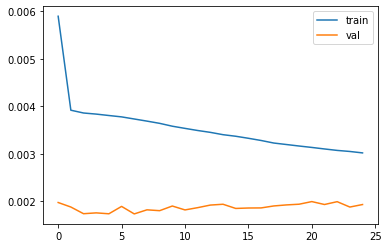

In [28]:
time_steps = trainX.shape[1]
features = trainX.shape[2]
pred_steps = output_period
pred_feat = 1

lstm_model = Sequential()

lstm_model.add(LSTM(50, return_sequences=False, input_shape=(time_steps, features)))
lstm_model.add(Dense(pred_steps*pred_feat))
lstm_model.add(Reshape([pred_steps, pred_feat]))

lstm_model.compile(loss="mse", optimizer="adam", metrics=["mse"]) # mae vs mse?

history = lstm_model.fit(trainX, trainY, epochs=25, validation_data=(valX, valY))

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

In [29]:
pred_val = lstm_model.predict(valX)
pred_val.shape

(21870, 21, 1)

In [30]:
pred_val[500, :]

array([[-0.00311598],
       [-0.00733262],
       [-0.01362393],
       [-0.01593927],
       [-0.01079847],
       [-0.01008802],
       [-0.00962761],
       [-0.01247251],
       [-0.01645772],
       [-0.01442749],
       [-0.01054981],
       [-0.01462413],
       [-0.01135021],
       [-0.01227543],
       [-0.01446269],
       [-0.01166365],
       [-0.00905864],
       [-0.01110401],
       [-0.01082075],
       [-0.00891634],
       [-0.01058891]], dtype=float32)

In [31]:
trainY[0, 20]

array([0.06282206], dtype=float32)

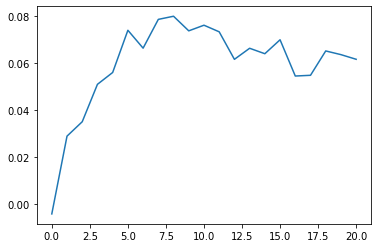

In [32]:
c = []
for i in range(output_period):
    c.append(np.corrcoef(pred_val[:, i, 0], valY[:, i, 0])[0][1])
plt.plot(c)

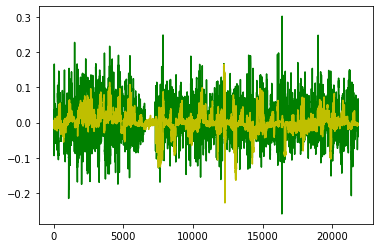

In [33]:
forecast_period = 15
plt.plot(valY[:, forecast_period, 0], c="g")
plt.plot(pred_val[:, forecast_period, 0], c="y")

In [34]:
len(c)

21

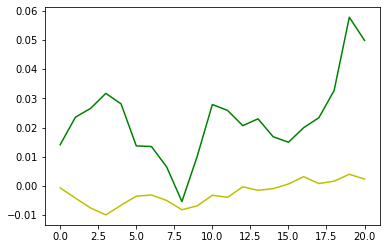

In [35]:
plt.plot(valY[3000, : , 0], c="g")
plt.plot(pred_val[300, : , 0], c="y")

In [36]:
pred_train = lstm_model.predict(trainX)

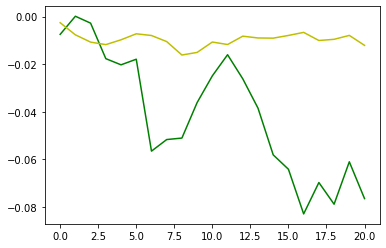

In [37]:
plt.plot(trainY[1000, : , 0], c="g")
plt.plot(pred_train[1000, : , 0], c="y")

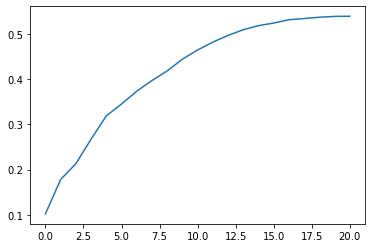

In [38]:
c = []
for i in range(output_period):
    c.append(np.corrcoef(pred_train[:, i, 0], trainY[:, i, 0])[0][1])
plt.plot(c)

In [39]:
pred_test = lstm_model.predict(testX)

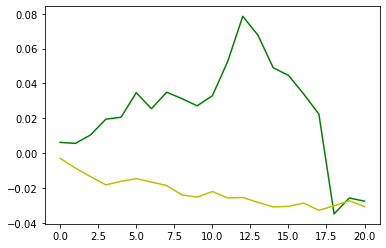

In [40]:
plt.plot(testY[100, : , 0], c="g")
plt.plot(pred_test[100, : , 0], c="y")

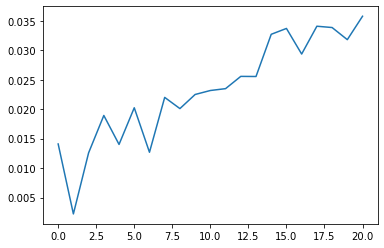

In [41]:
c = []
for i in range(output_period):
    c.append(np.corrcoef(pred_test[:, i, 0], testY[:, i, 0])[0][1])
plt.plot(c)

In [42]:
lstm_model.save("WEIGHTS")

INFO:tensorflow:Assets written to: WEIGHTS/assets


INFO:tensorflow:Assets written to: WEIGHTS/assets


In [43]:
import collections

In [44]:
rows = len(testStocks_Y[0])
row = 0
cash = 100
index = 100
stocks_to_buy = 15
forecast_horizon = 21
while row < rows:
    preds = {}
    for s in range(len(testStocks_X)):
        stock = np.array([testStocks_X[s][row, :, :]])
        pred = lstm_model.predict(stock)[0, forecast_horizon-1, 0]
        preds[s] = pred
    sorted_preds = collections.OrderedDict(preds)
    k = 0
    gains = 0
    index_gains = 0
    for w in sorted(sorted_preds, key=sorted_preds.get, reverse=True):
        outcome = testStocks_Y[w][row, forecast_horizon-1]
        forecast = sorted_preds[w]
        #print("FORECAST", sorted_preds[w], "OUTCOME", outcome)
        index_gains += index/len(stocks)*outcome 
        if (k<stocks_to_buy):
            if forecast > 0: # only buy on positive forecasts
                gains += cash/stocks_to_buy*outcome
        #if (k>=len(stocks)-stocks_to_buy): we don't want to short DJIA
        #    gains -= cash/stocks_to_buy*outcome
        k+=1
    cash += gains
    index += index_gains
    row += forecast_horizon
print("AI$", cash)
print("INDEX$", index)

AI$ [146.36537]
INDEX$ [164.9955]


In [45]:
stocks[0].index[5000]

Timestamp('2018-02-21 00:00:00')

In [46]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                18400     
_________________________________________________________________
dense (Dense)                (None, 21)                1071      
_________________________________________________________________
reshape (Reshape)            (None, 21, 1)             0         
Total params: 19,471
Trainable params: 19,471
Non-trainable params: 0
_________________________________________________________________


(41,)
[ 8 20 14 32 27 38 40  1 21  9  5 25 10 39  4 23 19  7 34 24 12 16 31 22  0  3  6 29 18 35 33 30  2 36 26 28 15 37 17 11 13]
WML
adv_sale
opmad
ptb
roa
lt_debt
cash_debt
Volume
de_ratio
rd_sale
RMW
aftret_equity
sale_invcap
pe_inc
HML
cash_lt
staff_sale
RF
debt_at
aftret_eq
ptpm
npm
bm
debt_assets
Adj Close
SMB
CMA
accrual
opmbd
totdebt_invcap
sale_equity
debt_capital
Mkt-RF
debt_invcap
at_turn
pcf
equity_invcap
capital_ratio
ps
GProf
gpm


'Weights'

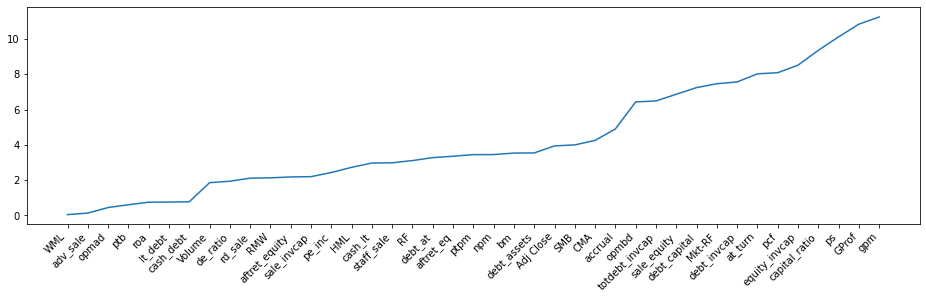

In [47]:
w = np.array(lstm_model.layers[0].get_weights()[0])
wi = w[:, :50] # number of units
inputs = abs(wi.sum(axis=1))
print(inputs.shape)
# ascending order
print(inputs.argsort())
for i in inputs.argsort():
    print(stocks[0].columns[i])
f, ax = plt.subplots(figsize=(16, 4))
ax.plot(inputs[inputs.argsort()])
ax.set_xticks(range(41))
plt.xticks(rotation=45, ha="right")
ax.set_xticklabels(stocks[0].columns[inputs.argsort()])
"Weights"

In [48]:
print(inputs[38], inputs[18])

0.75559425 6.430439
